## IMPORTS


In [36]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.10.1


## Hyperparameters

In [37]:
batch_size = 8
seq_len = 5
d_k = 64
d_v = 64
n_heads = 12
ff_dim = 64
learning_rate = 0.001

## Load  data

In [38]:
import yfinance as yf
from datetime import datetime, timedelta

def download_stock_data(ticker, years_back):
    end_date = datetime(2023, 12, 31)
    start_date = end_date - timedelta(days=years_back * 365)

    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Example Usage
ticker = 'AAPL'  # Replace with the desired ticker symbol
years_back = 3
historical_data = download_stock_data(ticker, years_back)
df = historical_data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-12-22,195.179993,195.410004,192.970001,193.600006,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,48087700
2023-12-28,194.139999,194.660004,193.169998,193.580002,34049900
2023-12-29,193.899994,194.399994,191.729996,192.529999,42628800


## Plot daily closing prices and volume

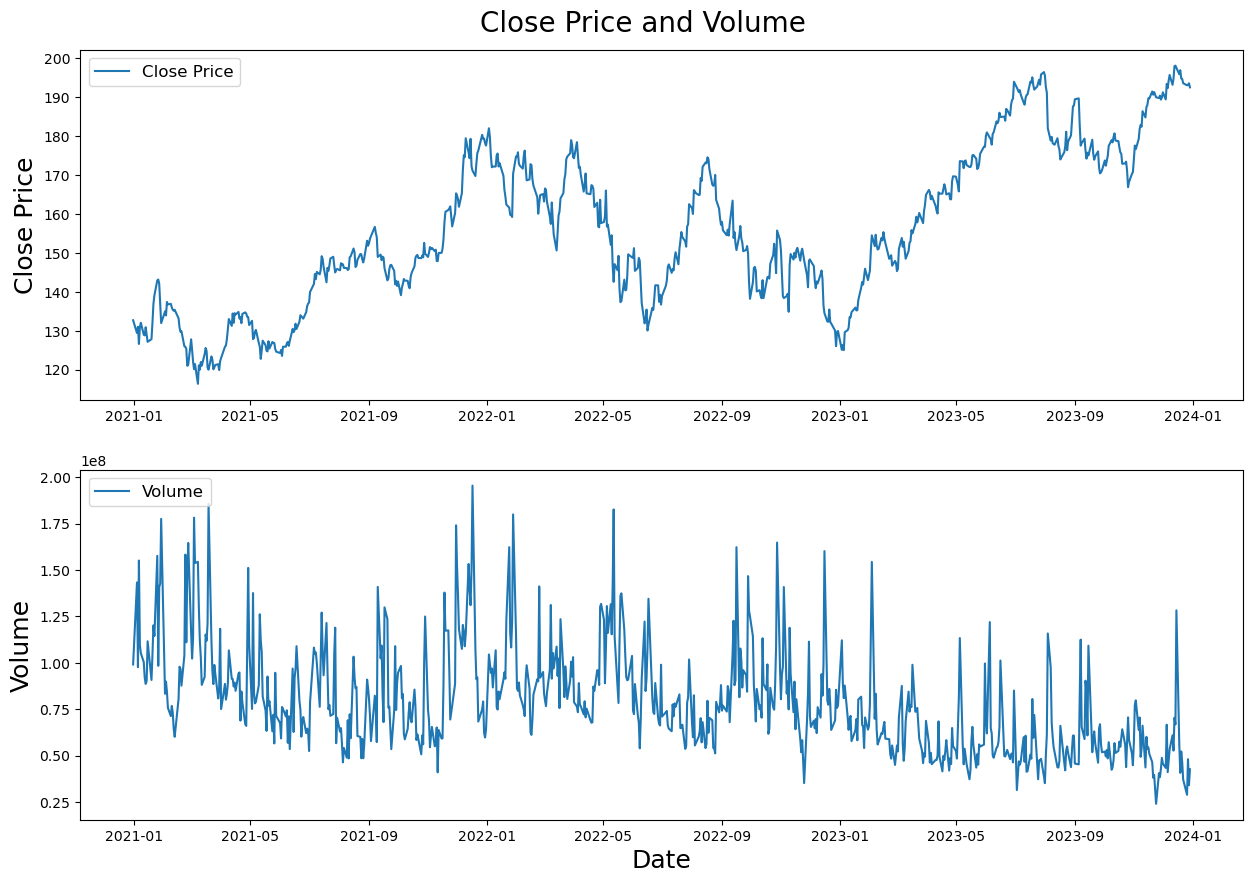

In [39]:


fig = plt.figure(figsize=(15, 10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df.index, df['Close'], label='Close Price')
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df.index, df['Volume'], label='Volume')
ax2.set_xlabel('Date', fontsize=18)  # Etiquetar el eje x con 'Date'
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

plt.show()


## Split and normalize

In [40]:
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_30pct = sorted(df.index.values)[-int(0.3*len(times))] # Last 30% of series

'''Split the data'''

df_train = df[df.index < last_30pct]  # Training data are 70% of total data
df_val = df[(df.index >= last_30pct) & (df.index < last_10pct)]
df_test = df[df.index >= last_10pct]

# Crear un diccionario para almacenar los normalizadores de cada columna
column_scalers = {}

# Recorrer todas las columnas del DataFrame para ajustar los normalizadores solo con los datos de entrenamiento
for column in df.columns:
    scaler = MinMaxScaler()
    # Ajustar el escalador solo con los datos de entrenamiento
    scaler.fit(df_train[[column]])
    
    # Transformar los datos de entrenamiento, validación y prueba
    df_train[column] = scaler.transform(df_train[[column]])
    df_val[column] = scaler.transform(df_val[[column]])
    df_test[column] = scaler.transform(df_test[[column]])
    
    # Guardar el escalador en el diccionario
    column_scalers[column] = scaler

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (528, 5)
Validation data shape: (151, 5)
Test data shape: (75, 5)


## Plot daily changes of close prices and volume

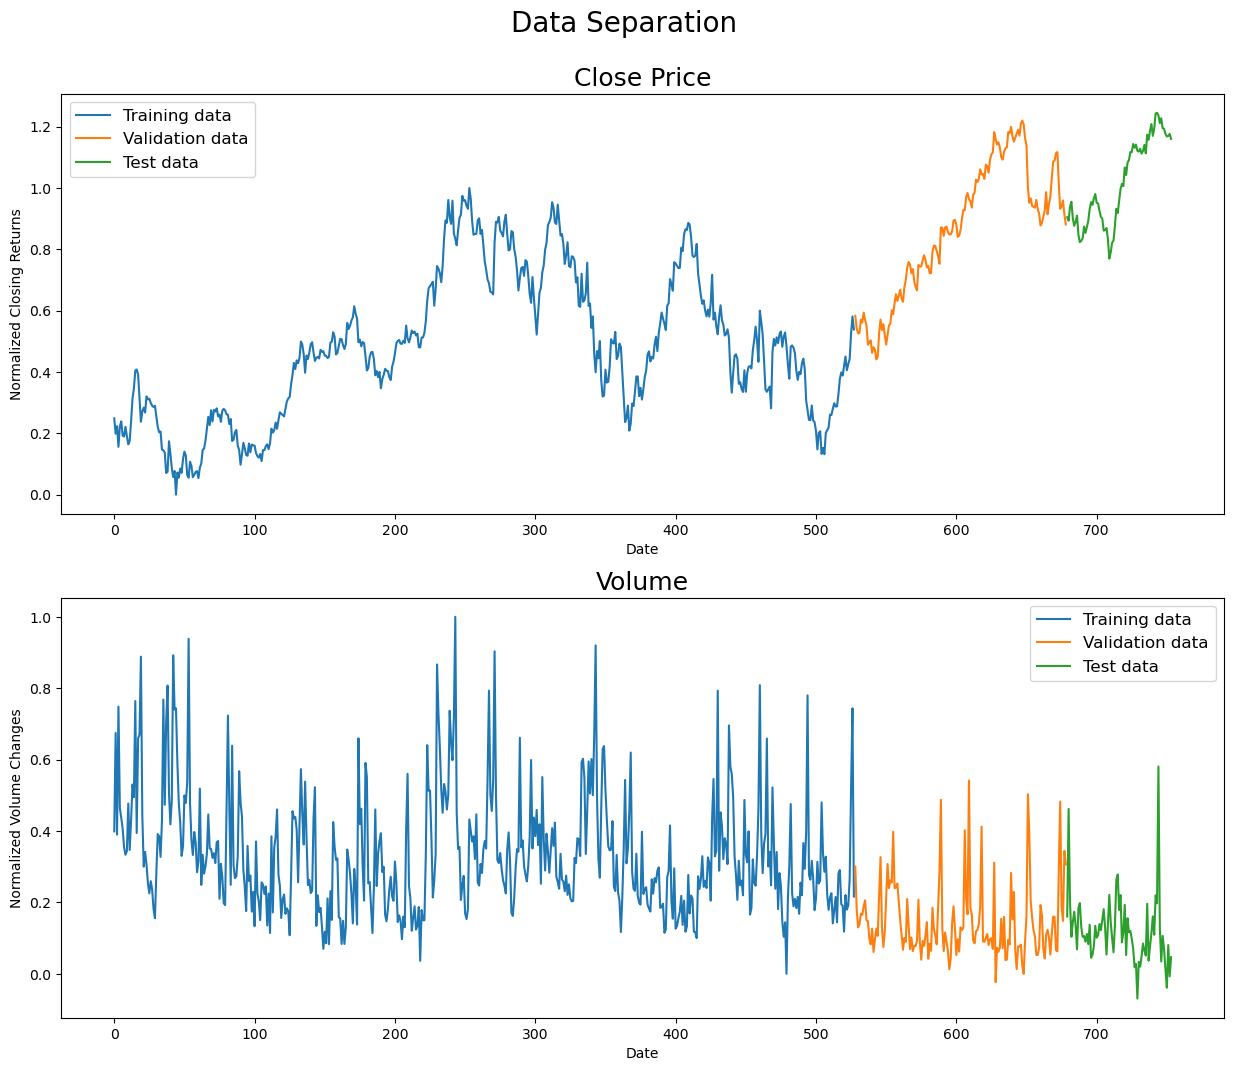

In [41]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [42]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (523, 5, 5) (523,)
Validation set shape (146, 5, 5) (146,)
Testing set shape (70, 5, 5) (70,)


## TimeVector

In [43]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [44]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 5)]       0           []                               
                                                                                                  
 time2_vector_2 (Time2Vector)   (None, 5, 2)         20          ['input_3[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 5, 7)         0           ['input_3[0][0]',                
                                                                  'time2_vector_2[0][0]']         
                                                                                                  
 transformer_encoder_6 (Transfo  (None, 5, 7)        24810       ['concatenate_2[0][0]',    

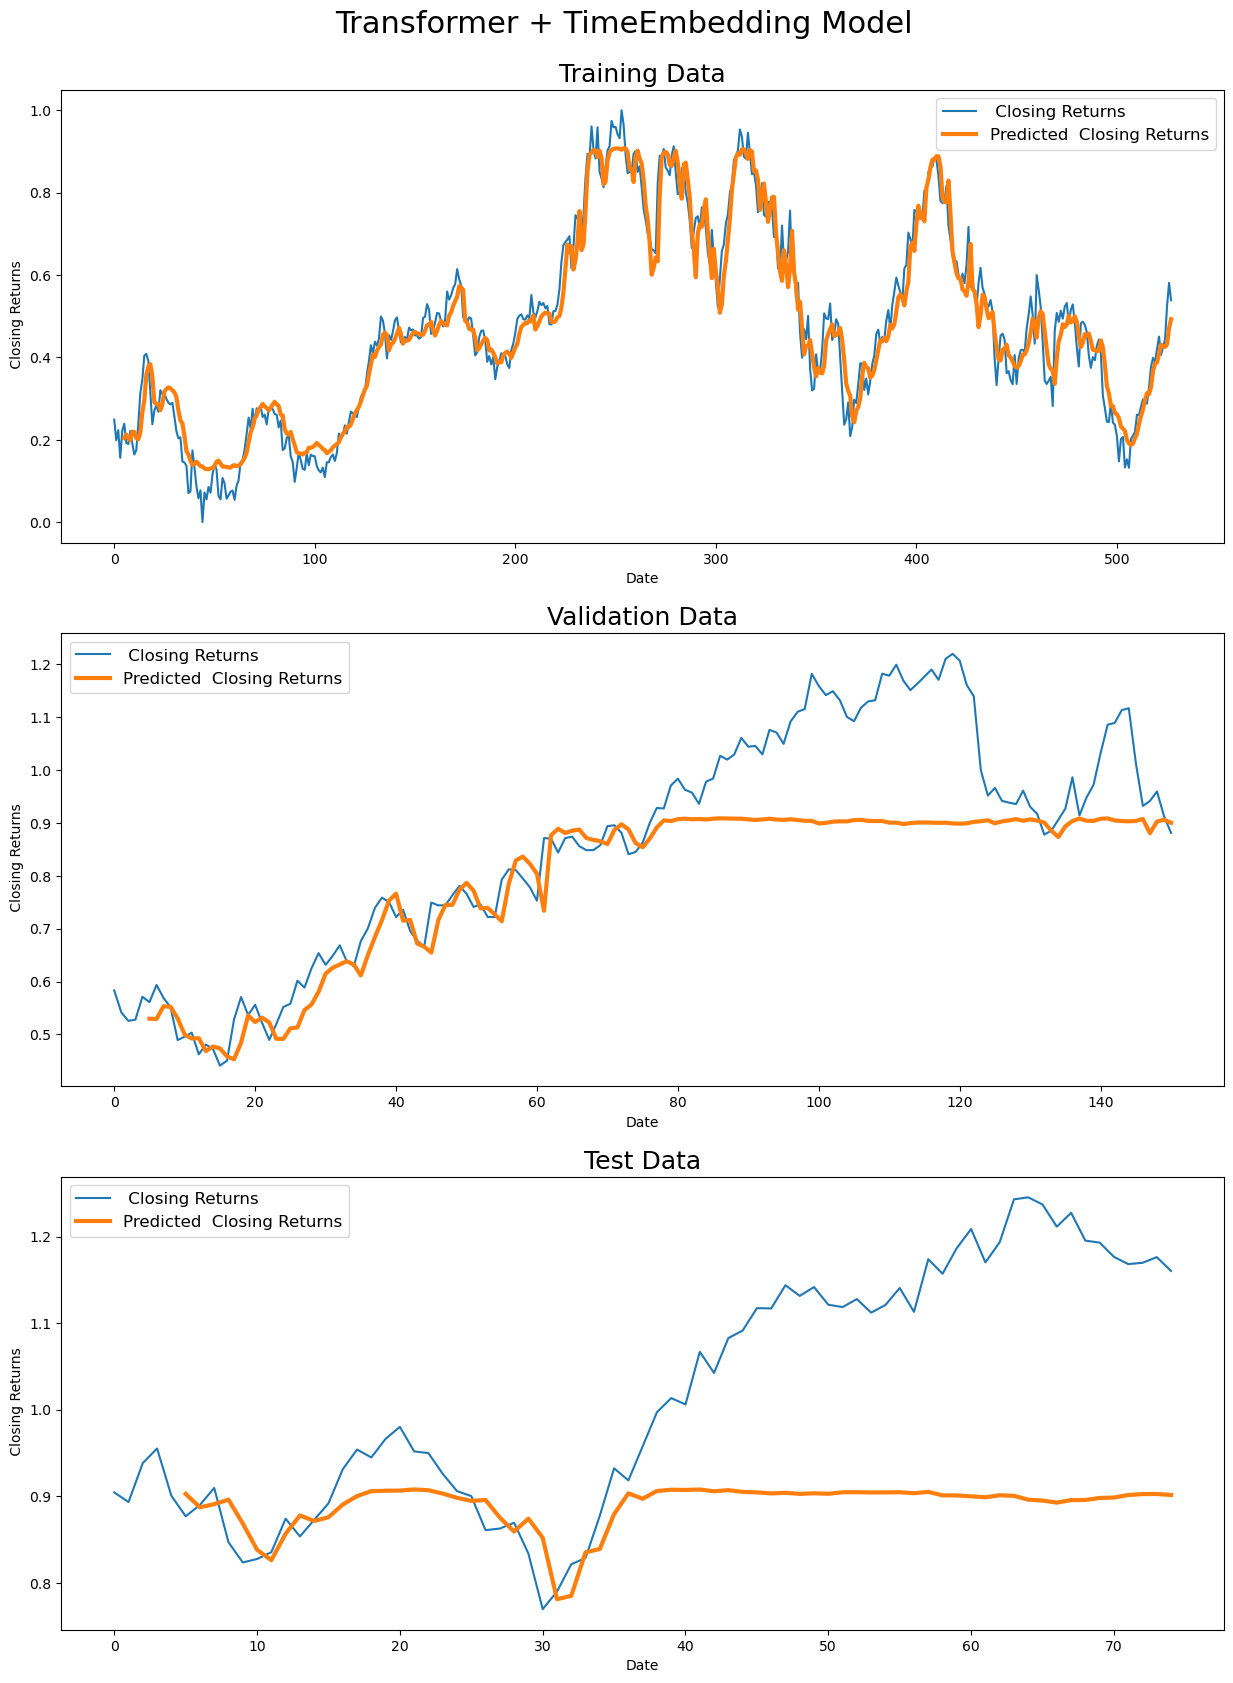

In [45]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.2)(x)
  out = Dense(1, activation='linear')(x)

  


  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics=['mae', 'mape'])
  return model

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Inicializar ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.0005, verbose=1)

model = create_model()
model.summary()



history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=50, 
                    callbacks=[early_stopping, reduce_lr],
                    validation_data=(X_val, y_val))  




###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label=' Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted  Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel(' Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label=' Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted  Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel(' Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label=' Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted  Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel(' Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

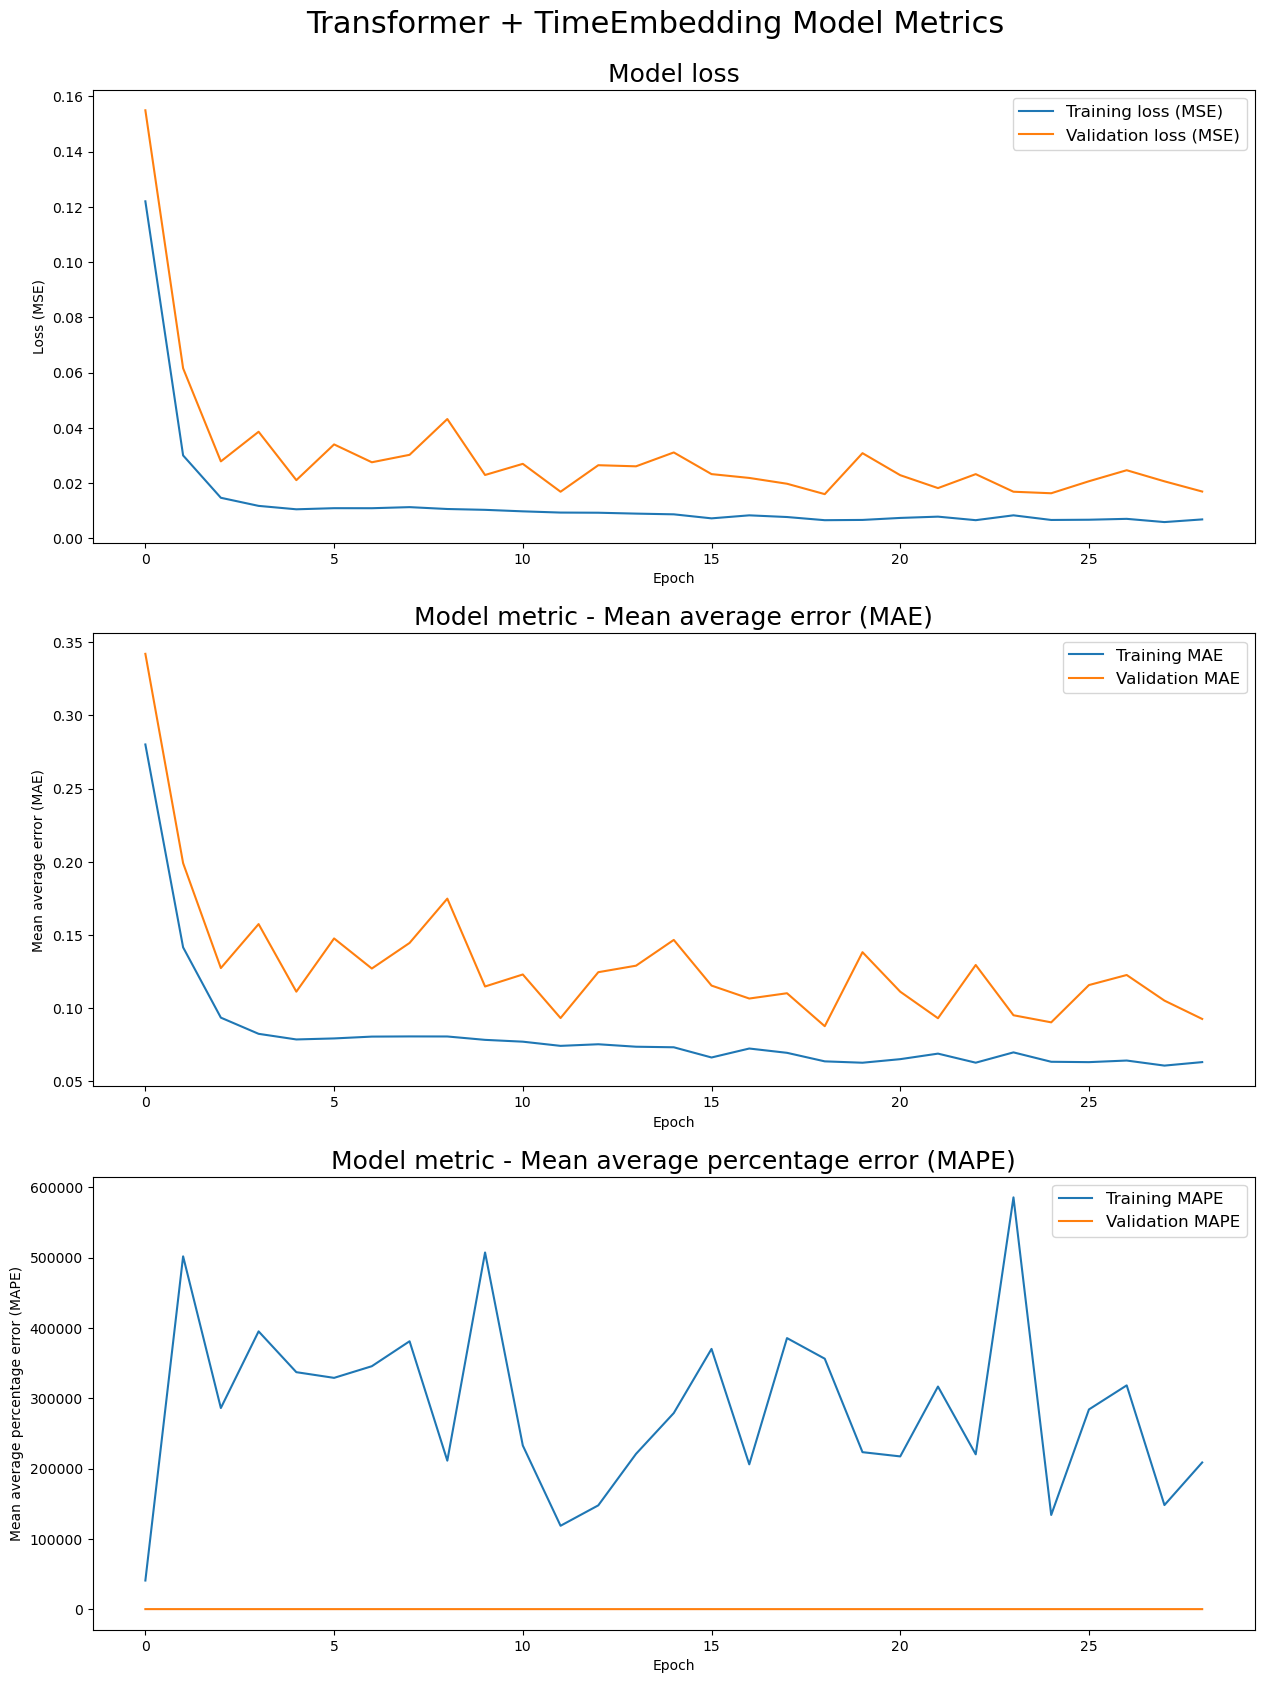

In [46]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [47]:
print(test_pred)

[[0.90276355]
 [0.8872624 ]
 [0.89099133]
 [0.8960942 ]
 [0.8685582 ]
 [0.83823586]
 [0.8262283 ]
 [0.856778  ]
 [0.877896  ]
 [0.8715177 ]
 [0.8758009 ]
 [0.8904682 ]
 [0.90023655]
 [0.90594244]
 [0.90643924]
 [0.9066199 ]
 [0.90791184]
 [0.9070122 ]
 [0.9031777 ]
 [0.89827853]
 [0.8947149 ]
 [0.89574045]
 [0.8754032 ]
 [0.85932386]
 [0.87421054]
 [0.8521885 ]
 [0.78120923]
 [0.78501683]
 [0.83527666]
 [0.839187  ]
 [0.87944555]
 [0.9033802 ]
 [0.8972213 ]
 [0.9060921 ]
 [0.9076192 ]
 [0.907319  ]
 [0.90782213]
 [0.90578383]
 [0.90708   ]
 [0.9051145 ]
 [0.90451366]
 [0.90335757]
 [0.9040285 ]
 [0.9027721 ]
 [0.9034986 ]
 [0.90290433]
 [0.9046454 ]
 [0.904754  ]
 [0.9044092 ]
 [0.904489  ]
 [0.9046828 ]
 [0.90358233]
 [0.90509254]
 [0.90108234]
 [0.90100276]
 [0.8999633 ]
 [0.89890754]
 [0.90122634]
 [0.9005263 ]
 [0.89609903]
 [0.89506453]
 [0.8926911 ]
 [0.8956138 ]
 [0.8957517 ]
 [0.898055  ]
 [0.89858574]
 [0.901477  ]
 [0.90255934]
 [0.90266436]
 [0.9015347 ]]


In [48]:
predicted_prices_original_scale = column_scalers['Close'].inverse_transform(test_pred.reshape(-1, 1))
print(predicted_prices_original_scale)

[[175.62642]
 [174.60876]
 [174.85358]
 [175.18858]
 [173.38084]
 [171.39018]
 [170.60188]
 [172.60748]
 [173.99387]
 [173.57513]
 [173.85632]
 [174.81923]
 [175.46053]
 [175.83511]
 [175.86774]
 [175.8796 ]
 [175.9644 ]
 [175.90535]
 [175.65361]
 [175.33197]
 [175.09802]
 [175.16536]
 [173.83022]
 [172.77461]
 [173.75192]
 [172.30617]
 [167.64638]
 [167.89635]
 [171.1959 ]
 [171.45264]
 [174.0956 ]
 [175.6669 ]
 [175.26257]
 [175.84494]
 [175.94519]
 [175.92549]
 [175.95851]
 [175.8247 ]
 [175.90979]
 [175.78076]
 [175.74132]
 [175.66542]
 [175.70946]
 [175.62698]
 [175.67468]
 [175.63567]
 [175.74997]
 [175.7571 ]
 [175.73445]
 [175.7397 ]
 [175.75243]
 [175.68018]
 [175.77931]
 [175.51605]
 [175.51083]
 [175.4426 ]
 [175.37328]
 [175.5255 ]
 [175.47954]
 [175.1889 ]
 [175.12099]
 [174.96516]
 [175.15704]
 [175.16609]
 [175.3173 ]
 [175.35216]
 [175.54196]
 [175.613  ]
 [175.61992]
 [175.54575]]


In [49]:
last_rows = historical_data.iloc[-len(predicted_prices_original_scale):]

# Crear un DataFrame con los precios predichos
df_predicted = pd.DataFrame(predicted_prices_original_scale, columns=['Predicted_Close'])

# Asegurarse de que el índice de df_predicted coincida con el de last_rows
df_predicted.index = last_rows.index

# Concatenar la columna 'Close' de historical_data con los precios predichos
result_df = pd.concat([last_rows['Close'], df_predicted], axis=1)

# Ahora result_df contiene los últimos registros de 'Close' y los precios predichos
print(result_df)


                 Close  Predicted_Close
Date                                   
2023-09-21  173.929993       175.626419
2023-09-22  174.789993       174.608765
2023-09-25  176.080002       174.853577
2023-09-26  171.960007       175.188583
2023-09-27  170.429993       173.380844
...                ...              ...
2023-12-22  193.600006       175.352158
2023-12-26  193.050003       175.541962
2023-12-27  193.149994       175.613007
2023-12-28  193.580002       175.619919
2023-12-29  192.529999       175.545746

[70 rows x 2 columns]


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

# Calcula el error cuadrático medio (MSE)
mse = mean_squared_error(result_df['Close'], result_df['Predicted_Close'])
print(f'Mean Squared Error (MSE): {mse}')

# Calcula el error absoluto medio (MAE)
mae = mean_absolute_error(result_df['Close'], result_df['Predicted_Close'])
print(f'Mean Absolute Error (MAE): {mae}')

# Calcula el MAPE
mape = mean_absolute_percentage_error(result_df['Close'], result_df['Predicted_Close'])
# Imprime el resultado
print(f'Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%')

Mean Squared Error (MSE): 144.9516533720706
Mean Absolute Error (MAE): 9.30833740234375
Mean Absolute Percentage Error (MAPE): 4.89%


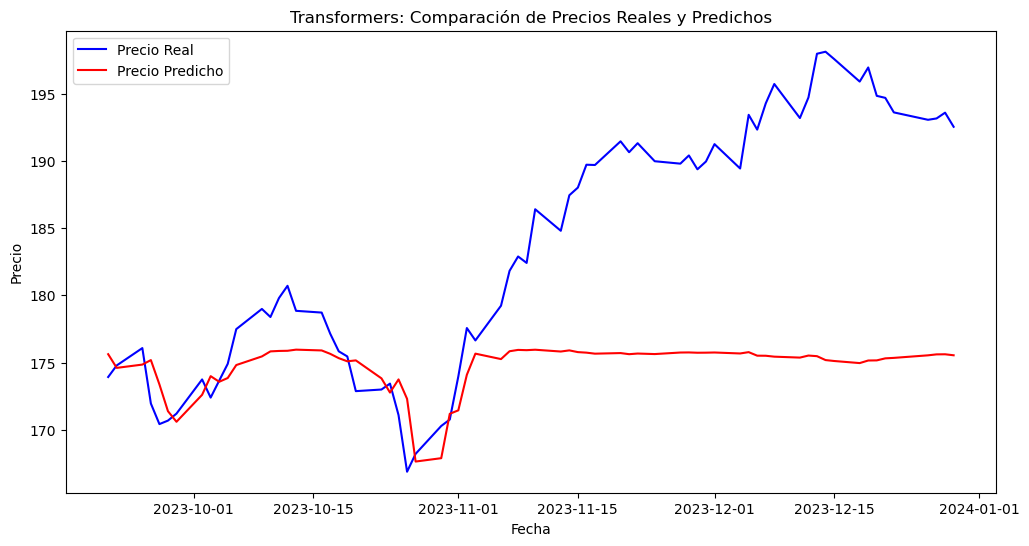

In [51]:

# Crear una figura para el gráfico
plt.figure(figsize=(12, 6))

# Graficar los precios reales
plt.plot(result_df['Close'], label='Precio Real', color='blue')

# Graficar los precios predichos
plt.plot(result_df['Predicted_Close'], label='Precio Predicho', color='red')

# Añadir título y etiquetas
plt.title('Transformers: Comparación de Precios Reales y Predichos')
plt.xlabel('Fecha')
plt.ylabel('Precio')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


## Model architecture overview

In [52]:
tf.keras.utils.plot_model(
    model,
    to_file="Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
